In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import sympy as sy
from tqdm import tqdm

## Dinámica del sistema

In [2]:
# # Species:
# ATP = 2
# ADP = 0.
# Pi = 0.              # mM
# NADPH = 2        # mM
# NADPplus = 0.     # mM
# Lys = 0.             # mMs

# # ___________ [2, 1., 2, 1., 0.1, 0.] ___________ #
# Aspi = 2.   # No mover
# AspPi = 0.00001  # No MOVER
# ASAi = 0.00001   # NO MOVER Nivel Máximo de Thr
# HSi = 0.
# HSPi = 0.
# Thri = 0.


# Constants:
# VAKI = 0.088                # Flag 0.068
# VAKIII = 0.0094             # Flag 0.0054             
# VASD = 2                    # Flag 2
# VHDH = 10                   # Flag 10
# VHK = 45                   # Flag 100
# VTS = 10
# VATP = 0.012
# VATPII = 500

# VAKI = 0.068
# VAKIII = 0.00088
# VASD = 2
# VHDH = 10
# VHK = 100
# VTS = 10

Dado que:
$$
\begin{align*} 
\frac{d}{dt} ATP &= -V_{AK}\cdot ATP \cdot ASP \\
\frac{d}{dt} ATP &= -V_{HK} \cdot ATP \cdot HS \\
\end{align*}
$$
Entonces:

$$
\begin{align*}
\frac{d}{dt} ATP &= -V_{AK} \cdot ATP \cdot ASP -V_{HK} \cdot ATP \cdot HS \\
\frac{d}{dt} ATP &= -ATP \cdot (V_{ATP} \cdot ASP + V_{HK} \cdot HS) \\
\frac{d}{dt} ATP &= -ATP \cdot \nu_{ATP} \\
\end{align*}
$$

$$
\begin{align*}
\frac{d}{dt} Asp &= -\nu_{AKI} - \nu_{AKIII} \\
\frac{d}{dt} AspP &= \nu_{AKI} + \nu_{AKIII} - \nu_{vASD} \\
\frac{d}{dt} ASA &= \nu_{ASD} - \nu_{HDH} \\
\frac{d}{dt} HS &= \nu_{HDH} - \nu_{HK} \\
\frac{d}{dt} HSP &= \nu_{HK} - \nu_{TS} \\
\frac{d}{dt} Thr &= \nu_{TS} \\
\frac{d}{dt} ATP &= -ATP \cdot \nu_{ATP} \\
\end{align*}
$$

<!-- $$
\begin{align*} -->
# <img src="images/System.png" width=900 height=380 />
<!-- % \end{align*}
% $$ -->

In [3]:
# Species:
ADP = 0.
Pi = 0.             # mM
NADPH = 2           # mM
NADPplus = 0.       # mM
Lys = 0.            # mMs
# ___________  ___________ #
Aspi = 2.           # No mover
AspPi = 0.00001     # No MOVER
ASAi = 0.00001      # NO MOVER Nivel Máximo de Thr
HSi = 0.
HSPi = 0.
Thri = 0.
ATPi = 2.


# Constants:
VAKI = 0.088                # Flag 0.068
VAKIII = 0.0094             # Flag 0.0054             
VASD = 2                    # Flag 2
VHDH = 10                   # Flag 10
VHK = 45                   # Flag 100
VTS = 10
VATP = 0.012
VATPII = 500


# Parameters:
# - nuAKI:
KeqAK = 6.4 * pow(10, -4)
KAspAKI = 0.97              # +- 0.48 mM
KATPAKI = 0.98              # +- 0.5 mM
KAspPAKI = 0.017            # +- 0.004 mM
KADPAKI = 0.25              # mM
KiThrAKI = 0.167            # +- 0.003 mM
h1 = 4.09                   # +- 0.26
alphaAKI = 2.47             # +- 0.17


# - nuAKIII:
KeqAK = 6.4 * pow(10, -4)
KAspAKII = 0.32             # +- 0.08 mM
KATPAKIII = 0.22            # +- 0.22 mM
KAspPAKIII = 0.017          # +- 0.004 mM
KADPAKIII = 0.25            # mM
K1Lys = 0.391               # +- 0.08 mM
hlys = 2.8                  # +- 1.4


# nuASD
KeqASD = 2.84 * pow(10, 5)
KAspPASD = 0.022            # +- 0.001 mM
KNADPHASD = 0.029           # +- 0.002 mM
KASAASD = 0.11              # +- 0.008 mM
KNADPplusASD = 0.144        # +- 0.02 mM 
KPi = 10.2                  # +- 1.4 mM


# nuHDH
KeqHDH = 1 * pow(10, 11)    # M^-1
KASAHDH = 0.24              # +- 0.03 mM
KNADPHHDH = 0.037           # +- 0.006 mM
KHSHDH = 3.39               # +- 0.33 mM
KNADPplusHDH = 0.067        # +- 0.006 mM
KNADPplusAKIII = 0.067      # +- 0.006 mM == KNADPplusHDH
KiThr2 = 0.097              # mM
h2 = 1.41
alpha2 = 3.93 


# nuHK
KHSHK = 0.11   # mM
KATPHK = 0.072 # mM
KiThrHK = 1.09 # mM
KiLysHK = 9.45 # mM
KiHSHK  = 4.7  # mM
KiATPHK = 4.35 # mM

# nuTS
KHSPTS = 0.31   # +- 0.03 mM

In [4]:
def system(t, r):
    Asp, AspP, ASA, HS, HSP, Thr, ATP= r
    νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
    νAKIII = (VAKIII * (Asp * ATP - (AspP * ADP/KeqAK))) / (1 + pow((Lys/K1Lys), hlys) * (KAspAKII*(1 + (AspP/KAspPAKIII)) + Asp)  * (KATPAKIII*(1 + (ADP/KADPAKIII)) + ATP))
    νASD = VASD * (AspP * NADPH - (ASA*NADPplus * Pi / KeqASD)) / (KAspPASD * (1 + (ASA / KASAASD)) * ( 1 + (Pi / KPi)) + AspP) * (KNADPHHDH * (1 + (NADPplus/ KNADPplusASD)) + NADPH)
    νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
    νHK = VHK * HS * ATP / (KHSHK*(ATP/KiATPHK)) * (1 + (Thr/KiThrHK) + HS) * (KATPHK * (1 + (HS / KiHSHK) + ATP)) * (1 + (Lys/KiLysHK))
    νTS = VTS*HSP/KHSPTS + HSP
    νATP = VATP * Asp + VATPII*HS

    dAsp    = -νAKI - νAKIII
    dAspP   =  νAKI + νAKIII - νASD
    dASA    =  νASD - νHDH
    dHS     =  νHDH - νHK
    dHSP    =  νHK  - νTS
    dThr    =  νTS
    dATP    =  - ATP * νATP

    return np.array([dAsp, dAspP, dASA, dHS, dHSP, dThr, dATP])

solved = solve_ivp(system, [0., 100.], [Aspi, AspPi,ASAi, HSi, HSPi, Thri, ATPi])

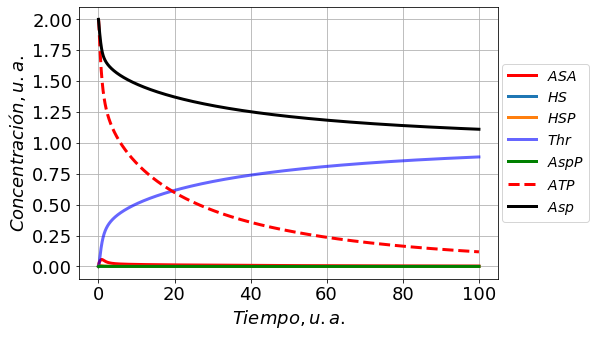

In [5]:
# figure = plt.figure(figsize=plt.figaspect(0.5))
figure = plt.figure(figsize=(7.5,5))
lw_ = 3

plt.plot(solved.t, solved.y[2], label=r'${ASA}$', color='red', lw=lw_)
plt.plot(solved.t, solved.y[3], label=r'${HS}$', lw=lw_)
plt.plot(solved.t, solved.y[4], label=r'${HSP}$', lw=lw_)
plt.plot(solved.t, solved.y[5], label=r'${Thr}$', color='blue', alpha=0.6, lw=lw_)
plt.plot(solved.t, solved.y[1], label=r'${AspP}$', color='green', lw=lw_)
plt.plot(solved.t, solved.y[6], '--',label=r'${ATP}$',color='red', lw=lw_)
plt.plot(solved.t, solved.y[0], label=r'${Asp}$', color='black', lw=lw_)

plt.legend(loc='center right', bbox_to_anchor=(1.235, 0.50),
          ncol=1, fancybox=True, shadow=False, fontsize=14)
plt.grid(True)
plt.xlabel(r'${Tiempo, u.a.}$', fontsize=18)
plt.ylabel(r'${Concentración, u.a.}$', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('Threonine_dynamics.png', bbox_inches='tight')
plt.show()

# <img src="images/Concentration.png" width=500 height=320 />

## Efecto de las concentraciones iniciales

In [6]:
def find_optimal_concentration(range_concentration=3, factor=1, constant=None, tmax=100.):
    solved_systems = []
    for i in tqdm(range(range_concentration)):
        i *= factor
        # ___________  ___________ #
        AspPi = 0.00001     
        ASAi = 0.00001      
        HSi = 0.
        HSPi = 0.
        Thri = 0.

        if constant == False:
            Aspi = 2. + i
            ATPi = 2. + i

        elif constant == 'ATP':
            Aspi = 2. + i
            ATPi = 2.
        
        elif constant == 'Asp':
            Aspi = 2.
            ATPi = 2. + i

        elif constant == True:
            Aspi = 2.
            ATPi = 2.

        solved = solve_ivp(system, [0., tmax], [Aspi, AspPi,ASAi, HSi, HSPi, Thri, ATPi])
        solved_systems.append(solved)
    return solved_systems

In [7]:
factor = 10
solved_systems = find_optimal_concentration(range_concentration=12, factor=factor, constant=False, tmax=100.);

  8%|███▋                                        | 1/12 [00:01<00:16,  1.54s/it]/tmp/ipykernel_10567/2054372985.py:3: RuntimeWarning: invalid value encountered in double_scalars
  νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
/tmp/ipykernel_10567/2054372985.py:6: RuntimeWarning: invalid value encountered in double_scalars
  νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
100%|███████████████████████████████████████████| 12/12 [04:41<00:00, 23.44s/it]


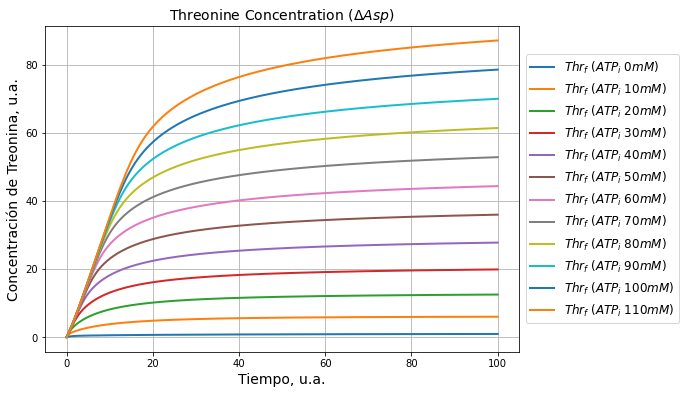

In [33]:
figure = plt.figure(figsize=(8.5,6))
[plt.plot(solved_systems[i].t, solved_systems[i].y[5], label=f'$Thr_f\;(ATP_i \; {i * factor} mM$)', lw=2) for i in range(len(solved_systems))]
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.50),
          ncol=1, fancybox=True, shadow=False, fontsize=12)
plt.title(r'Threonine Concentration ($\Delta{Asp})$', fontsize=14)
plt.xlabel('Tiempo, u.a.', fontsize=14)
plt.ylabel('Concentración de Treonina, u.a.', fontsize=14)
plt.grid(True)

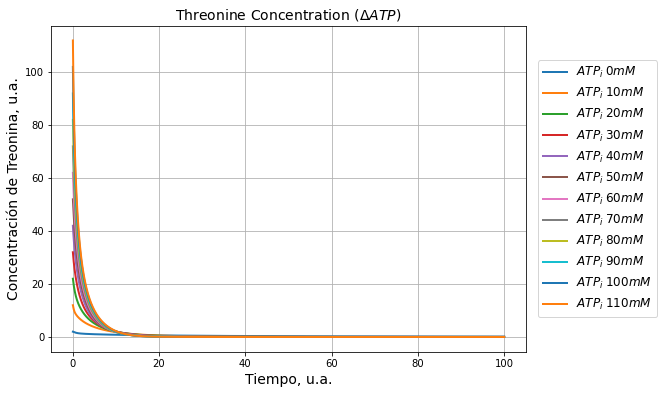

In [29]:
figure = plt.figure(figsize=(8.5,6))
[plt.plot(solved_systems[i].t, solved_systems[i].y[6], label=f'$ATP_i \;{i*factor} mM$', lw=2) for i in range(len(solved_systems))]
plt.legend(loc='center right', bbox_to_anchor=(1.29, 0.50),
          ncol=1, fancybox=True, shadow=False, fontsize=12)
plt.title(r'Threonine Concentration ($\Delta{ATP})$', fontsize=14)
plt.xlabel('Tiempo, u.a.', fontsize=14)
plt.ylabel('Concentración de Treonina, u.a.', fontsize=14)
plt.grid(True)
plt.show()

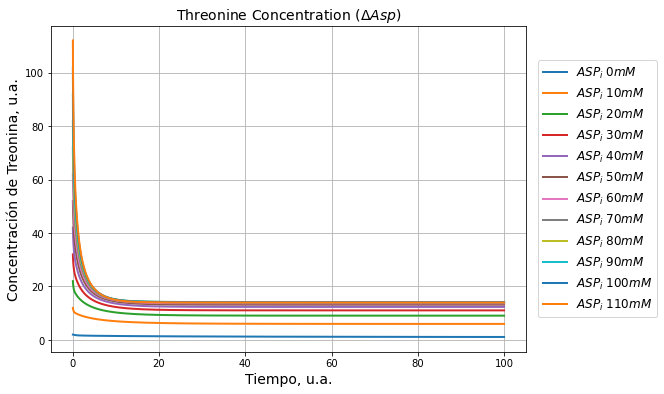

In [28]:
figure = plt.figure(figsize=(8.5,6))
[plt.plot(solved_systems[i].t, solved_systems[i].y[0], label=f'$ASP_i \;{i*factor} mM$', lw=2) for i in range(len(solved_systems))]
plt.legend(loc='center right', bbox_to_anchor=(1.29, 0.50),
          ncol=1, fancybox=True, shadow=False, fontsize=12)
plt.title(r'Threonine Concentration ($\Delta{Asp})$', fontsize=14)
plt.xlabel('Tiempo, u.a.', fontsize=14)
plt.ylabel('Concentración de Treonina, u.a.', fontsize=14)
plt.grid(True)
plt.show()

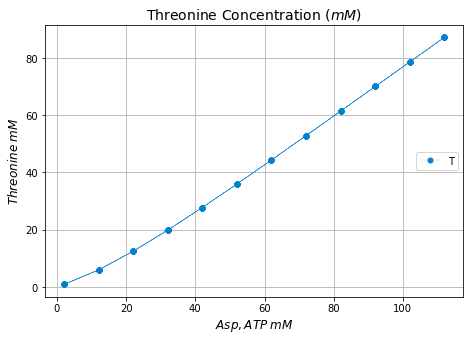

In [9]:
figure = plt.figure(figsize=(7.5,5))
x = [solved_systems[i].y[0][0] for i in range(len(solved_systems))];
y = [solved_systems[i].y[5][-1] for i in range(len(solved_systems))];
[plt.plot(x, y, '--', color='#0082D1',marker='o', lw=0.2, ms=5)  for i in range(len(solved_systems))];
plt.title(r'Threonine Concentration ($mM$)', fontsize=14);
plt.xlabel(r'${Asp, ATP}\;mM$', fontsize=12);
plt.ylabel(r'$Threonine\;mM$', fontsize=12);
plt.legend('T',loc=5);
plt.grid(True)

## Optimización de parámetros cinéticos

In [11]:
def find_optimal_constant(constants=[0.001, 0.01, 0.1, 1.], factor=1, tmax=100.):
    solved_systems = []
    for constant in tqdm(constants):
        # Species:
        ADP = 0.
        Pi = 0.             # mM
        NADPH = 2           # mM
        NADPplus = 0.       # mM
        Lys = 0.            # mMs
        # ___________  ___________ #
        Aspi = 2.           # No mover
        AspPi = 0.00001     # No MOVER
        ASAi = 0.00001      # NO MOVER Nivel Máximo de Thr
        HSi = 0.
        HSPi = 0.
        Thri = 0.
        ATPi = 2.


        # Parameters:
        # - nuAKI:
        KeqAK = 6.4 * pow(10, -4)
        KAspAKI = 0.97              # +- 0.48 mM
        KATPAKI = 0.98              # +- 0.5 mM
        KAspPAKI = 0.017            # +- 0.004 mM
        KADPAKI = 0.25              # mM
        # KiThrAKI = 0.167            # +- 0.003 mM   # Modify
        h1 = 4.09                   # +- 0.26
        alphaAKI = 2.47             # +- 0.17


        # - nuAKIII:
        KeqAK = 6.4 * pow(10, -4)
        KAspAKII = 0.32             # +- 0.08 mM
        KATPAKIII = 0.22            # +- 0.22 mM
        KAspPAKIII = 0.017          # +- 0.004 mM
        KADPAKIII = 0.25            # mM
        # K1Lys = 0.391               # +- 0.08 mM    # Modify
        hlys = 2.8                  # +- 1.4


        # nuASD
        KeqASD = 2.84 * pow(10, 5)
        KAspPASD = 0.022            # +- 0.001 mM
        KNADPHASD = 0.029           # +- 0.002 mM
        KASAASD = 0.11              # +- 0.008 mM
        KNADPplusASD = 0.144        # +- 0.02 mM 
        # KPi = 10.2                # +- 1.4 mM             # Modify


        # nuHDH
        KeqHDH = 1 * pow(10, 11)    # M^-1
        KASAHDH = 0.24              # +- 0.03 mM
        KNADPHHDH = 0.037           # +- 0.006 mM
        KHSHDH = 3.39               # +- 0.33 mM
        KNADPplusHDH = 0.067        # +- 0.006 mM
        KNADPplusAKIII = 0.067      # +- 0.006 mM == KNADPplusHDH
        # KiThr2 = 0.097              # mM                            # Modify
        h2 = 1.41
        alpha2 = 3.93 


        # nuHK
        KHSHK = 0.11   # mM
        KATPHK = 0.072 # mM
        # KiThrHK = 1.09 # mM         # Modify
        # KiLysHK = 9.45 # mM         # Modify
        # KiHSHK  = 4.7  # mM         # Modify
        # KiATPHK = 4.35 # mM         # Modify

        # nuTS
        KHSPTS = 0.31   # +- 0.03 mM
        
        # Constants:
        VAKI = 0.088                # Flag 0.068
        VAKIII = 0.0094             # Flag 0.0054             
        VASD = 2                    # Flag 2
        VHDH = 10                   # Flag 10
        VHK = 45                    # Flag 100
        VTS = 10
        VATP = 0.012
        VATPII = 500
        
        # Inhibition Constants:
        global KiThrAKI
        KiThrAKI = 0.00001 + constant              # +- 0.003 mM   # Modify | 0.167
        K1Lys = 0.391                 # +- 0.08 mM    # Modify | 0.391 # No tiene un impacto mayor
        KPi = 10.2                  # +- 1.4 mM     # Modify
        KiThr2 = 0.097              # mM            # Modify
        KiThrHK = 1.09              # mM            # Modify
        KiLysHK = 9.45              # mM            # Modify
        KiHSHK  = 4.7               # mM            # Modify
        KiATPHK = 4.35              # mM            # Modify

        solved = solve_ivp(system, [0., tmax], [Aspi, AspPi,ASAi, HSi, HSPi, Thri, ATPi])
        solved_systems.append(solved)

    return solved_systems

In [12]:
d_cons_System = find_optimal_constant(constants=[0.001, 0.01, 0.1, 1., 10., 100.], factor=1, tmax=100.)

100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.50s/it]


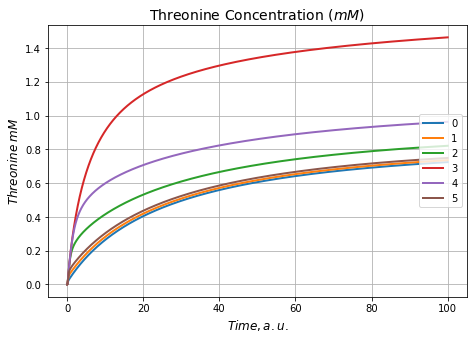

In [13]:
# Aspi, AspPi,ASAi, HSi, HSPi, Thri, ATPi
figure = plt.figure(figsize=(7.5,5))
[plt.plot(d_cons_System[i].t, d_cons_System[i].y[5], label=f'{i}', lw=2)  for i in range(len(d_cons_System))];
plt.title(r'Threonine Concentration ($mM$)', fontsize=14);
plt.xlabel(r'${Time, a.u.}$', fontsize=12);
plt.ylabel(r'$Threonine\;mM$', fontsize=12);
plt.legend(loc=5);
plt.grid(True)

In [18]:
# constants = ('Asp', 'ATP', False, True)
# multiple_solved_systems = [find_optimal_concentration(range_concentration=3, factor=1, constant=constant) for constant in constants]
# System_cAsp ,System_cATP, System_delta, System_constant = multiple_solved_systems

# x = [System_delta[i].y[0][0] for i in range(len(System_cAsp))];
# y = [System_delta[i].y[0][-1] for i in range(len(System_cAsp))];
# [plt.plot(x, y, color='blue', marker='o', lw=0, ms=5, alpha=0.3)  for i in range(len(System_cAsp))];

## Análisis de estabilidad

In [58]:
def system(r):
    Asp, AspP, ASA, HS, HSP, Thr, ATP = r
    νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
    νAKIII = (VAKIII * (Asp * ATP - (AspP * ADP/KeqAK))) / (1 + pow((Lys/K1Lys), hlys) * (KAspAKII*(1 + (AspP/KAspPAKIII)) + Asp)  * (KATPAKIII*(1 + (ADP/KADPAKIII)) + ATP))
    νASD = VASD * (AspP * NADPH - (ASA*NADPplus * Pi / KeqASD)) / (KAspPASD * (1 + (ASA / KASAASD)) * ( 1 + (Pi / KPi)) + AspP) * (KNADPHHDH * (1 + (NADPplus/ KNADPplusASD)) + NADPH)
    νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
    νHK = VHK * HS * ATP / (KHSHK*(ATP/KiATPHK)) * (1 + (Thr/KiThrHK) + HS) * (KATPHK * (1 + (HS / KiHSHK) + ATP)) * (1 + (Lys/KiLysHK))
    νTS = VTS*HSP/KHSPTS + HSP
    νATP = VATP * Asp + VATPII*HS

    dAsp    = -νAKI - νAKIII
    dAspP   =  νAKI + νAKIII - νASD
    dASA    =  νASD - νHDH
    dHS     =  νHDH - νHK
    dHSP    =  νHK  - νTS
    dThr    =  νTS
    dATP    =  - ATP * νATP

    return np.array([dAsp, dAspP, dASA, dHS, dHSP, dThr, dATP])

ss = least_squares(system, np.array([1, 1, 1, 1, 1, 1, 1]))
ss.x

array([ 2.57269125e-14,  6.51954471e-21, -9.99999919e-01,  6.67205696e-17,
        3.18766224e-21,  1.26648802e+02,  5.51773352e-03])

In [60]:
Asp, AspP, ASA, HS, HSP, Thr, ATP = sy.symbols('Asp AspP ASA HS HSP Thr ATP')
νAKI = VAKI*(Asp*ATP - (AspP*ADP/KeqAK)) / (KAspAKI*(1 + pow((Thr/KiThrAKI), h1) / 1 + pow((Thr/alphaAKI*KiThrAKI), h1)) + AspP*((KAspAKI/KAspPAKI)) + Asp)*(KATPAKI*(1 + (ADP/KADPAKI)) + ATP)
νAKIII = (VAKIII * (Asp * ATP - (AspP * ADP/KeqAK))) / (1 + pow((Lys/K1Lys), hlys) * (KAspAKII*(1 + (AspP/KAspPAKIII)) + Asp)  * (KATPAKIII*(1 + (ADP/KADPAKIII)) + ATP))
νASD = VASD * (AspP * NADPH - (ASA*NADPplus * Pi / KeqASD)) / (KAspPASD * (1 + (ASA / KASAASD)) * ( 1 + (Pi / KPi)) + AspP) * (KNADPHHDH * (1 + (NADPplus/ KNADPplusASD)) + NADPH)
νHDH = VHDH * (ASA * NADPH - (HS * NADPplus/KeqHDH)) / (1 + pow((Thr/KiThr2), h2) / 1 + pow((Thr/alpha2*KiThr2), h2)) * KASAHDH*(1 + (HS/KHSHDH) + ASA) * (KNADPHHDH * (1 + (NADPplus/KNADPplusAKIII)) + NADPH)
νHK = VHK * HS * ATP / (KHSHK*(ATP/KiATPHK)) * (1 + (Thr/KiThrHK) + HS) * (KATPHK * (1 + (HS / KiHSHK) + ATP)) * (1 + (Lys/KiLysHK))
νTS = VTS*HSP/KHSPTS + HSP
νATP = VATP * Asp + VATPII*HS

In [61]:
X = sy.Matrix([-νAKI - νAKIII, νAKI + νAKIII - νASD, νASD - νHDH, νHDH - νHK, νHK  - νTS, νTS, - ATP * νATP])
X

Matrix([
[                                                                -0.088*ATP*Asp*(ATP + 0.98)/(Asp + 57.0588235294118*AspP + 1465.08010864367*Thr**4.09 + 0.97) - 0.0094*ATP*Asp],
[                           0.088*ATP*Asp*(ATP + 0.98)/(Asp + 57.0588235294118*AspP + 1465.08010864367*Thr**4.09 + 0.97) + 0.0094*ATP*Asp - 8.148*AspP/(0.2*ASA + AspP + 0.022)],
[                                                           -9.7776*ASA*(ASA + 0.294985250737463*HS + 1)/(26.8373371575812*Thr**1.41 + 1) + 8.148*AspP/(0.2*ASA + AspP + 0.022)],
[9.7776*ASA*(ASA + 0.294985250737463*HS + 1)/(26.8373371575812*Thr**1.41 + 1) - 1779.54545454545*HS*(0.072*ATP + 0.0153191489361702*HS + 0.072)*(HS + 0.91743119266055*Thr + 1)],
[                                                         1779.54545454545*HS*(0.072*ATP + 0.0153191489361702*HS + 0.072)*(HS + 0.91743119266055*Thr + 1) - 33.258064516129*HSP],
[                                                                                                    

In [63]:
Y = sy.Matrix([Asp, AspP, ASA, HS, HSP, Thr, ATP])
Y

Matrix([
[ Asp],
[AspP],
[ ASA],
[  HS],
[ HSP],
[ Thr],
[ ATP]])

In [64]:
jacob = X.jacobian(Y)
jacob

Matrix([
[ 4.09977410643112e-8*ATP*Asp*(ATP + 0.98)/(0.000682556533325522*Asp + 0.038945872783868*AspP + Thr**4.09 + 0.000662079837325756)**2 - 0.088*ATP*(ATP + 0.98)/(Asp + 57.0588235294118*AspP + 1465.08010864367*Thr**4.09 + 0.97) - 0.0094*ATP,                                                                            2.33928287249305e-6*ATP*Asp*(ATP + 0.98)/(0.000682556533325522*Asp + 0.038945872783868*AspP + Thr**4.09 + 0.000662079837325756)**2,                                                                                                                                                                 0,                                                                                                                                                                                                                                                                                           0,                0,                          0.000245665747474522*ATP*Asp*Thr**3.09*(ATP + 0.98)/(0.

In [66]:
jacob_ss = jacob.evalf(5, subs={Asp:ss.x[0], AspP:ss.x[1], ASA:ss.x[2], HS:ss.x[3], HSP:ss.x[4], Thr:ss.x[5], ATP:ss.x[6]})
jacob_ss

Matrix([
[-5.1867e-5, 2.0683e-39,           0,          0,       0,  6.8221e-31, -2.4183e-16],
[ 5.1867e-5,     45.775,  3.3532e-19,          0,       0, -6.8221e-31,  2.4183e-16],
[         0,    -45.775,  0.00039519, 0.00011658,       0, -3.5752e-13,           0],
[         0,          0, -0.00039519,   -15098.0,       0,  3.4963e-13, -1.0018e-12],
[         0,          0,           0,    15098.0, -33.258,  7.8861e-15,  1.0018e-12],
[         0,          0,           0,          0,  33.258,           0,           0],
[-6.6213e-5,          0,           0,    -2.7589,       0,           0, -3.3669e-14]])

In [72]:
jacob_ss = np.array(jacob_ss).astype(np.float64)
jacob_ss

array([[-5.18666930e-05,  2.06832494e-39,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  6.82209525e-31,
        -2.41832989e-16],
       [ 5.18666930e-05,  4.57752686e+01,  3.35319168e-19,
         0.00000000e+00,  0.00000000e+00, -6.82209525e-31,
         2.41832989e-16],
       [ 0.00000000e+00, -4.57752686e+01,  3.95191833e-04,
         1.16575742e-04,  0.00000000e+00, -3.57516967e-13,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -3.95191833e-04,
        -1.50982812e+04,  0.00000000e+00,  3.49630914e-13,
        -1.00183750e-12],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.50982812e+04, -3.32580566e+01,  7.88614779e-15,
         1.00183750e-12],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.32580566e+01,  0.00000000e+00,
         0.00000000e+00],
       [-6.62128441e-05,  0.00000000e+00,  0.00000000e+00,
        -2.75886536e+00,  0.00000000e+00,  0.00000000e+00,
        -3.3669031

In [74]:
eig_vals = np.linalg.eigvals(jacob_ss)
eig_vals

array([-1.50982812e+04,  4.57752686e+01, -3.32580566e+01, -5.18666931e-05,
        3.95191831e-04, -3.31772447e-14,  9.48008138e-20])